# Big Picture: Neural Operators and the Math Behind Fourier Neural Operators

In traditional machine learning, models learn a function  
$$
f: \mathbb{R}^n \to \mathbb{R}^m,
$$  
i.e., a mapping between finite-dimensional vector spaces. This is suitable for structured data like images, sequences, or tabular data.

However, many problems in physics and engineering involve **functions as inputs and outputs** — for example, solving a **parametric partial differential equation (PDE)**:

$$
\mathcal{G}_y: a(x) \mapsto u(x),
$$

where:
- \( a(x) \) is an **input function** (e.g., diffusivity, initial condition),
- \( u(x) \) is the **solution function** (e.g., temperature, velocity),
- and $ \mathcal{G}_y $ is the **solution operator** of the PDE with parameters \( y \).

This setting lives in **infinite-dimensional Banach spaces**:
- $ a \in A \subseteq \mathcal{B}_a $,  
- $ u \in U \subseteq \mathcal{B}_u $,  
where $ \mathcal{B}_a, \mathcal{B}_u $ are typically function spaces like $ L^2(D) $ or $ C(D) $.

---

## The Learning Objective

Given finite observations $ \{(a_j, u_j)\}_{j=1}^N $, sampled from a distribution $ \mu $ over $ A $, the goal is to approximate the solution operator:

$$
\mathcal{G}_\theta \approx \mathcal{G}_y,
$$

by minimizing an expected loss:

$$
\min_{\theta \in \Theta} \ \mathbb{E}_{a \sim \mu} \left[ \mathcal{L}\left( \mathcal{G}_\theta(a), \mathcal{G}_y(a) \right) \right],
$$

where $ \mathcal{L} $ is a suitable cost functional (e.g., $ L^2 $ loss).

This is a **learning problem between function spaces** — not just finite vectors. That’s what makes Neural Operators powerful.

---

## Neural Operators

A **Neural Operator** is a deep architecture designed to learn this operator $ \mathcal{G}_y $ directly. It typically consists of:

1. **Lifting layer**: transforms the input function $ a(x) $ to a high-dimensional representation $ v_0(x) $,
2. **Operator layers**: iterative updates of the form:

$$
v_{t+1}(x) = \phi\left( W v_t(x) + \left(\mathcal{K}(a;\theta)v_t\right)(x) \right),
$$

where:
- $ W $ is a learned local linear transformation (e.g., 1x1 Conv),
- $ \phi $ is a nonlinearity,
- $ \mathcal{K}(a;\theta) $ is a **kernel integral operator**, parameterized by neural nets, which gives **nonlocal/global interactions**.

3. **Projection layer**: maps the final representation $ v_T(x) $ to the output function $ u(x) $.

---

## Fourier Neural Operators (FNO)

The Fourier Neural Operator makes this kernel operation efficient by switching to **Fourier space**:

### Step-by-step:

1. **Fourier Transform** the input features:
   $$
   \hat{v}_t = \mathcal{F}(v_t)
   $$
2. **Truncate high-frequency modes** to first \( K \) modes
3. **Multiply by complex-valued weight tensor** $ \hat{W} $ (learned):
   $$
   \hat{v}_{t+1}(k) = \hat{W}(k) \cdot \hat{v}_t(k), \quad k \leq K
   $$
4. **Set the rest to zero**
5. **Inverse Fourier Transform** to return to real space:
   $$
   v_{t+1} = \mathcal{F}^{-1}(\hat{v}_{t+1})
   $$

This allows FNOs to:
- **Capture long-range dependencies** efficiently (global kernels),
- **Scale well to high-dimensional problems**, unlike classical kernel methods,
- **Generalize across resolutions** (i.e., zero-shot superresolution),
- Reduce computation by discarding high-frequency noise.

---

## ✅ Summary

Fourier Neural Operators are a new class of models that:
- Learn mappings between **functions**, not just finite-dimensional vectors,
- Use **spectral convolutions** for global context and efficiency,
- Generalize across a **family of PDEs** with a single model,
- Enable **fast, mesh-independent** inference.

They represent a bridge between **classical numerical analysis** and **modern deep learning**, unlocking new frontiers in scientific computing, weather prediction, fluid dynamics, and more.



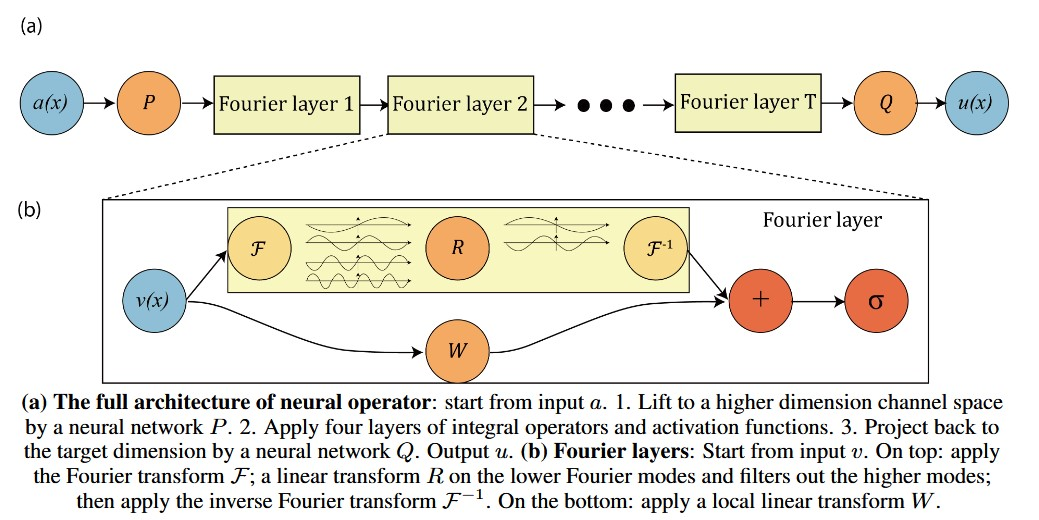
# Introduction to implementation
Neural Operators are mappings between discretized function spaces, for example:

- Map from an initial condition to the solution function at a later point in time (or to the entire spatiotemporal solution function)
- Map from the function describing an inhomogeneous diffusivity distribution to the solution of the heat equation
- Autoregressive timesteppers, map state $ u_h^{[t]} $ to state $ u_h^{[t+1]} $

Fourier Neural Operators do so by employing the FFT to perform efficient **spectral convolution** taking into account global features. In that sense they are a multiscale architecture (Classical convolutional architectures are only local and their receptive field depends on the depth of the network).

Neural Operators allow for the solution of a whole parametric family of PDEs!

FNOs allow for zero-shot superresolution.


# Spectral Convolutions

Given the (real-valued) input discretized state $a$ (with potentially more than one channel) defined on an equidistant mesh; do the following steps:

1. Transform $a$ into Fourier space (using the real-valued Fourier transform): $\hat{a} = \text{rfft}(a)$ (batch over the channel dimension)  
2. step $R$ : Perform a batched matrix multiplication with a complex-valued weight vector $W$ for the first $K$ modes: $\hat{a}_{0:K} = W \hat{a}_{0:K}$  
3. Set all the leftover modes to zero: $\hat{a}_K = 0 + 0i$  
4. Transform back into real space: $\tilde{a} = \text{irfft}(\hat{a})$

The learnable parameters for each spectral convolution are the complex-valued weight matrix of shape  
**(channels_out, channels_in, modes)**  
(Since it is complex-valued, it actually has  
**2 × channels_out × channels_in × modes** real parameters)

---

# Fourier Neural Operator

A classical FNO consists of a lifting layer, multiple "ResNet"-like blocks of spectral convolutions with a bypass, and a projection layer.  
Projection and lifting layers are 1×1 convolutions to only modify the channel dimensions. The blocks operate as:

$$
b = \text{activation}(\hat{a} + \text{Conv1x1}(a))
$$

We will mimic one example from the original paper by [Li et al.](https://arxiv.org/abs/2010.08895), as implemented in their [reference code](https://github.com/zongyi-li/fourier_neural_operator), to solve the 1D Burgers' equation:

$$
\frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial u^2}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

The domain $\Omega = (0, 2\pi)$ is periodic (i.e., $u(t, x=0) = u(t, x=2\pi)$), and the diffusivity is fixed to $\nu = 0.1$.  
Our dataset consists of 2048 initial conditions $u(t=0, x)$ on an $N = 8192$ resolution, together with their solution at time one $u(t=1, x)$.

The goal of the FNO is to learn the mapping from initial condition to state at time one using classical supervised learning.  
The input to the network is the input state channel, concatenated with the spatial coordinates of the mesh points.  
The output is just the state at time one.


In [3]:
%pip install equinox
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm

In [18]:
import jax

In [4]:
#Dataset
!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
data = scipy.io.loadmat("burgers_data_R10.mat")

--2025-04-09 18:28:45--  https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
Resolving ssd.mathworks.com (ssd.mathworks.com)... 23.214.102.204
Connecting to ssd.mathworks.com (ssd.mathworks.com)|23.214.102.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644427710 (615M) [text/plain]
Saving to: ‘burgers_data_R10.mat’

burgers_data_R10.ma 100%[===================>] 614.57M  62.3MB/s    in 11s     

2025-04-09 18:28:57 (55.1 MB/s) - ‘burgers_data_R10.mat’ saved [644427710/644427710]



In [5]:
a, u = data["a"], data["u"]

In [6]:
a.shape
#(number of sample, spatial points we have available)

(2048, 8192)

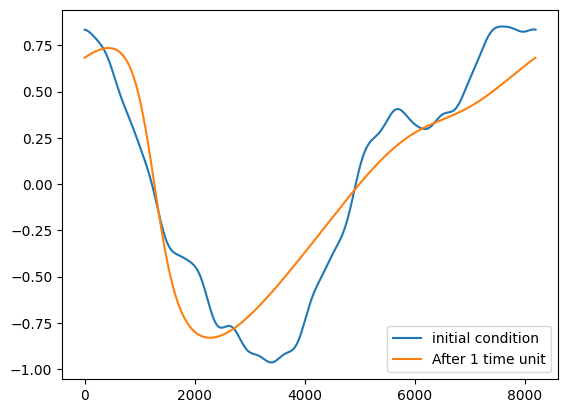

In [7]:
plt.plot(a[0], label="initial condition")
plt.plot(u[0], label="After 1 time unit")
plt.legend()
#Initial condition is a periodic function.

In [8]:
#Add channel dimension
a = a[:, jnp.newaxis, :]
u = u[:, jnp.newaxis, :]

In [9]:
#mesh is from 0 to 2 pi
mesh = jnp.linspace(0, 2*jnp.pi, u.shape[-1])

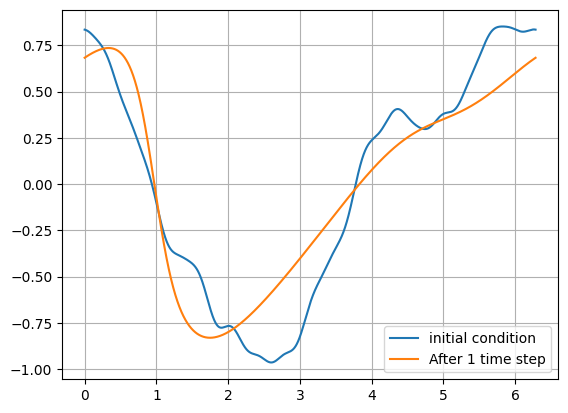

In [10]:
plt.plot(mesh, a[0,0], label= "initial condition")
plt.plot(mesh, u[0,0], label= "After 1 time step")
plt.legend()
plt.grid()


In [11]:
mesh_shape_corrected = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, : ], u.shape[0], axis=0)
a_with_mesh = jnp.concatenate((a, mesh_shape_corrected), axis=1)

In [12]:
a_with_mesh.shape

(2048, 2, 8192)

In [13]:
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000: 1200]

In [19]:
class SpectralConv1d(eqx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(
        self,
        in_channels,
        out_channels,
        modes,
        *,
        key,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        scale = 1.0 / (in_channels * out_channels)

        real_key, imag_key = jax.random.split(key)
        self.real_weights = jax.random.uniform(
            real_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )
        self.imag_weights = jax.random.uniform(
            imag_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )

    def complex_mult1d(
        self,
        x_hat,
        w,
    ):
        return jnp.einsum("iM, iOM->OM", x_hat, w)

    def __call__(
        self,
        x,
    ):
        channels, spatial_points = x.shape

        # shape of x_hat is (in_channels, spatial_points//2+1)
        x_hat = jnp.fft.rfft(x)

        # shape of x_hat_under_modes is (in_channels, self.modes)
        x_hat_under_modes = x_hat[:, :self.modes]

        weights = self.real_weights + 1j * self.imag_weights

        # shape of out_hat_under_modes is (out_channels, self.modes)
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)

        # shape of out_hat is (out_channels, spatial_points//2+1)
        out_hat = jnp.zeros(
            (self.out_channels, x_hat.shape[-1]),
            dtype=x_hat.dtype
        )

        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)

        out = jnp.fft.irfft(out_hat, n=spatial_points)

        return out


In [20]:
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass_conv: eqx.nn.Conv1d
    activation: Callable

    def __init__(
        self,
        in_channels,
        out_channels,
        modes,
        activation,
        *,
        key,
    ):
        spectral_conv_key, bypass_conv_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key,
        )
        self.bypass_conv = eqx.nn.Conv1d(
            in_channels,
            out_channels,
            1,  # Kernel size is one
            key=bypass_conv_key,
        )
        self.activation = activation

    def __call__(
        self,
        x,
    ):
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )


In [21]:
class FNO1d(eqx.Module):
    lifting: eqx.nn.Conv1d
    fno_blocks: List[FNOBlock1d]
    projection: eqx.nn.Conv1d

    def __init__(
        self,
        in_channels,
        out_channels,
        modes,
        width,
        activation,
        n_blocks = 4,
        *,
        key,
    ):
        key, lifting_key = jax.random.split(key)
        self.lifting = eqx.nn.Conv1d(
            in_channels,
            width,
            1,
            key=lifting_key,
        )

        self.fno_blocks = []
        for i in range(n_blocks):
            key, subkey = jax.random.split(key)
            self.fno_blocks.append(FNOBlock1d(
                width,
                width,
                modes,
                activation,
                key=subkey,
            ))

        key, projection_key = jax.random.split(key)
        self.projection = eqx.nn.Conv1d(
            width,
            out_channels,
            1,
            key=projection_key,
        )

    def __call__(
        self,
        x,
    ):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)

        return x


In [22]:
fno = FNO1d(
    2,
    1,
    16,
    64,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)


In [23]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]


In [24]:
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x[..., ::32], test_y[..., ::32])
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(200)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::32],
        train_y[..., ::32],
        batch_size=100,
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)


  0%|          | 0/200 [00:00<?, ?it/s]

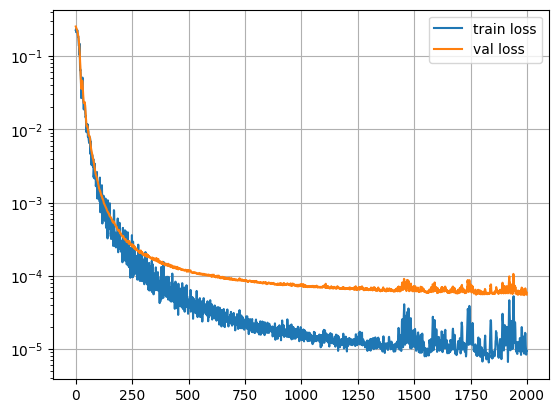

In [25]:
plt.plot(loss_history, label='train loss')
plt.plot(val_loss_history, label='val loss')
plt.legend()
plt.yscale('log')
plt.grid()


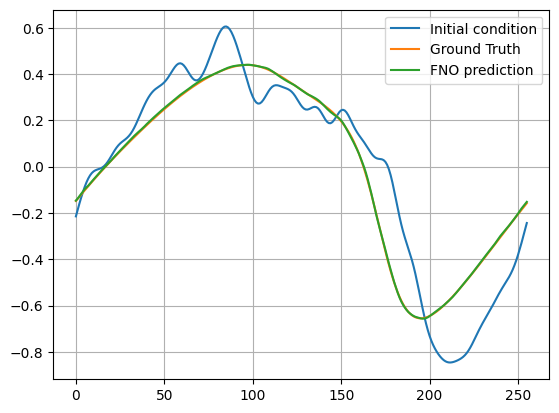

In [26]:
plt.plot(test_x[1, 0, ::32], label="Initial condition")
plt.plot(test_y[1, 0, ::32], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::32])[0], label="FNO prediction")
plt.legend()
plt.grid()

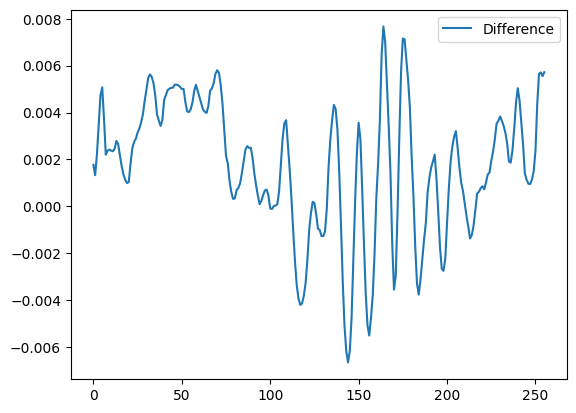

In [27]:
plt.plot(fno(test_x[1, :, ::32])[0] - test_y[1, 0, ::32], label="Difference")
plt.legend()


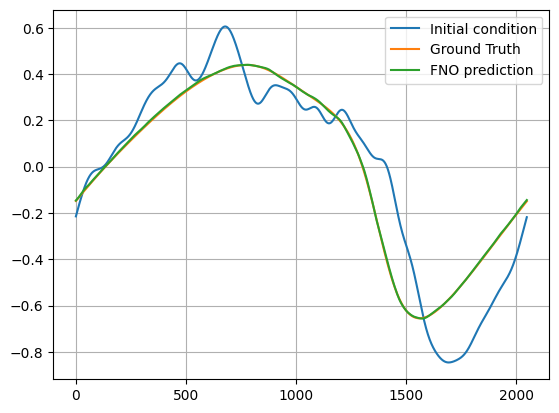

In [28]:
# Zero-Shot superresolution
plt.plot(test_x[1, 0, ::4], label="Initial condition")
plt.plot(test_y[1, 0, ::4], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::4])[0], label="FNO prediction")
plt.legend()
plt.grid()


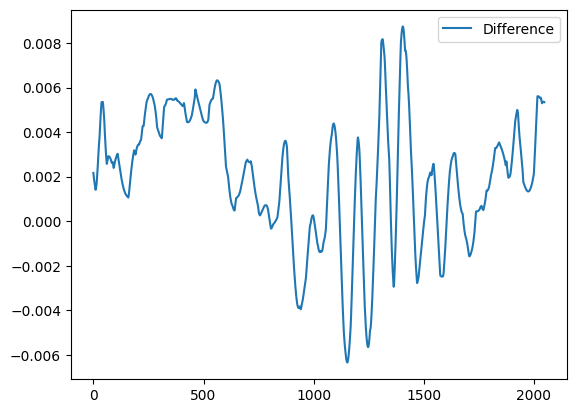

In [29]:
plt.plot(fno(test_x[1, :, ::4])[0] - test_y[1, 0, ::4], label="Difference")
plt.legend()


In [30]:
# Compute the error as reported in the FNO paper
test_pred = jax.vmap(fno)(test_x)

def relative_l2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

rel_l2_set = jax.vmap(relative_l2_norm)(test_pred, test_y)

In [31]:
rel_l2_set.shape

(200,)

In [32]:
jnp.mean(rel_l2_set)

Array(0.01204151, dtype=float32)